# Website Notebook

In [1]:
# Standard imports
# If any of these don't work, try doing `pip install _____`, or try looking up the error message.
import numpy as np
import pandas as pd
import json
import time
import os.path
from os import path
import math
import datetime
import unidecode
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modules from sportsrefernece.ncaab for college basketball
from sportsreference.ncaab.boxscore import Boxscore as NCAAB_Boxscore
from sportsreference.ncaab.conferences import Conferences as NCAAB_Conferences
from sportsreference.ncaab.rankings import Rankings as NCAAB_Rankings
from sportsreference.ncaab.roster import Player as NCAAB_Player
from sportsreference.ncaab.roster import Roster as NCAAB_Roster
from sportsreference.ncaab.schedule import Schedule as NCAAB_Schedule
from sportsreference.ncaab.teams import Teams as NCAAB_Teams

# Modules from sportsrefernece.nba for NBA basketball
from sportsreference.nba.boxscore import Boxscore as NBA_Boxscore
from sportsreference.nba.roster import Player as NBA_Player
from sportsreference.nba.roster import Roster as NBA_Roster
from sportsreference.nba.schedule import Schedule as NBA_Schedule
from sportsreference.nba.teams import Teams as NBA_Teams

# Introduction

Hi everyone! In this notebook, we will be constructing a variety of different machine learning models to predict NBA rookie statlines from different college players input from the Anvil App!

Let's get started!

# A. College Data

**In order for us to pass up college stats for this player to be viewed in the front-end, we will need to:**
1. Clean the name
2. Find the college player stats for the input name
    - If they don't exist, tell the user that they don't, and provide the correct error message

### 1. Find college player stats for input name

In [3]:
# This method should hopefully reduce the number of failure cases.
def convert_nba_ncaa_name(name: str) -> str:
    """
    Converts the format of the NBA player_id to the NCAA player_id.

    You may want to elaborate on the logic on this function to reduce the number of failure cases later.
    """
    return unidecode.unidecode(name.lower().replace(" ", "-") + "-1")

### 2. Find the college player stats for the input name

In [4]:
def get_college_stats(player_name: str) -> dict:
    """
    Return a dictionary with the following keys:
    
    success: If the player was correctly found (boolean)
    data: Player data (pd.Dataframe)
    error: Error message, if success is false (string)
    """
    response = {}
    clean_name = convert_nba_ncaa_name(player_name)
    
    # Checking if player does exist with current name
    try:
        player_data = NCAAB_Player(clean_name).dataframe
    except TypeError:
        response['success'] = False
        response['data'] = None
        response['error'] = "This player doesn't exist (or its name is not in the correct format). Please try a different player name."
        return response

    player_data.rename(columns=lambda x: 'NCAAB_' + x, inplace=True)
    last_year = player_data.iloc[[player_data.shape[0] - 2]]
    last_year.set_index(pd.Index(data=[player_name], name='Name'), inplace=True)
    
    response['success'] = True
    response['data'] = last_year # Change for Matt's formatting
    response['error'] = None
    return response

In [5]:
ayton = get_college_stats('Deandre Ayton')

In [6]:
ayton['data']

,NCAAB_assist_percentage,NCAAB_assists,NCAAB_block_percentage,NCAAB_blocks,NCAAB_box_plus_minus,NCAAB_conference,NCAAB_defensive_box_plus_minus,NCAAB_defensive_rebound_percentage,NCAAB_defensive_rebounds,NCAAB_defensive_win_shares,...,NCAAB_true_shooting_percentage,NCAAB_turnover_percentage,NCAAB_turnovers,NCAAB_two_point_attempts,NCAAB_two_point_percentage,NCAAB_two_pointers,NCAAB_usage_percentage,NCAAB_weight,NCAAB_win_shares,NCAAB_win_shares_per_40_minutes
Name,,,,,,,,,,,,,,,,,,,,,
Deandre Ayton,10.2,57,6.1,66,10.9,pac-12,4.0,28.2,287,2.1,...,0.65,11.3,69,416,0.635,264,26.6,250,7.6,0.259


In [7]:
# Pip install the library if you don't currently have it
!pip install anvil-uplink

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


### Making front-end endpoint for retrieving college data

In [8]:
import anvil.server
anvil.server.connect("GNJSCKQAJWGXCULZ5AFCTV5W-GAZKXCLKC2XXURJE")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK


In [9]:
@anvil.server.callable
def get_college(name):
    """
    Making the front-end to back-end connection, and passing up college data.
    """
    response = get_college_stats(name)
    if not response['success']:
        return response
    
    column_names = ['NCAAB_' + name for name in ['points', 'total_rebounds', 'assists', 'steals', 'blocks', 'games_played']]
    
    def rename_cols(name):
        """
        Rename columns
        """
        new_names = {
            'NCAAB_points': 'pts',
            'NCAAB_total_rebounds': 'reb',
            'NCAAB_assists': 'ast',
            'NCAAB_steals': 'stl',
            'NCAAB_blocks': 'blk',
        }
        if name == 'Name':
            return name
        return new_names[name]
    
    new_data = response['data']
    per_game = (new_data[column_names] / int(new_data['NCAAB_games_played'].values)).drop(columns=['NCAAB_games_played'])
    renamed = per_game.iloc[0].apply(lambda x: round(x, 2)).rename(lambda x: rename_cols(x))
    renamed['Name'] = name
    response['data'] = [renamed.to_dict()]
    return response

In [10]:
get_college('Ben Simmons')

{'success': True,
 'data': [{'pts': 19.15,
   'reb': 11.76,
   'ast': 4.79,
   'stl': 1.97,
   'blk': 0.82,
   'Name': 'Ben Simmons'}],
 'error': None}

In [11]:
get_college('Stephen Curry')

{'success': True,
 'data': [{'pts': 28.65,
   'reb': 4.44,
   'ast': 5.56,
   'stl': 2.53,
   'blk': 0.24,
   'Name': 'Stephen Curry'}],
 'error': None}

# B. Clean/Process Data

In [12]:
# Splitting data
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/player_data_final.csv')
NBA_col = ['NBA_points', 'NBA_total_rebounds', 'NBA_assists', 'NBA_steals', 'NBA_blocks']
train, test = data.drop(columns=NBA_col), data[NBA_col].set_index(pd.Index(data=data['name'], name='name'))
train.set_index('name', inplace=True)

In [13]:
def check_null(df):
    """
    Returns all columns that have a null value in the player's data
    """
    return df.columns[df.isna().any()].tolist()

**In order for us to make predictions from the college data to be rendering in the front-end, we first need to:**
1. Drop unneeded columns
2. Clean the data the same way we did in our initial data

### 1. Drop unneeded columns

In [14]:
def drop_columns(data: pd.DataFrame) -> pd.DataFrame:
    """
    Drops the columns from the input college data.
    """
    def drop_for_nans(data):
        # Drops columns due to NaNs inside the data.
        drop_col = [
            'NCAAB_box_plus_minus',
            'NCAAB_defensive_box_plus_minus',
            'NCAAB_offensive_box_plus_minus',
            'NCAAB_player_efficiency_rating',
            'NCAAB_three_point_percentage',
        ]
        return data.drop(columns=drop_col)
    
    def drop_for_qual(data):
        # Drops columns due to qualitative data
        qual_drop = [
            'NCAAB_conference', 
            'NCAAB_player_id',
            'NCAAB_team_abbreviation',
        ]
        return data.drop(columns=qual_drop)
    
    return drop_for_nans(drop_for_qual(data))

In [15]:
curry = get_college_stats('Stephen Curry')

In [16]:
new_curry = drop_columns(curry['data'])

In [17]:
check_null(new_curry)

['NCAAB_defensive_rebound_percentage',
 'NCAAB_offensive_rebound_percentage',
 'NCAAB_points_produced',
 'NCAAB_steal_percentage']

### 2. Clean the data the same way we did initially

In [18]:
def clean_qualitative(data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the qualitative columns (height, position)
    """

    def convert_height(height: str) -> int:
        """
        Convert height from string to int (6-11 -> 83)
        """
        feet, inches = height.split("-")
        return int(feet) * 12 + int(inches)

    def clean_position(position: str) -> str:
        """
        If the player has a hypened position, remove the second one.
        """
        return position.split('-')[0]
    
    def one_hot_position(player):
        """
        Applies one hot encoding to the player's position.
        """
        positions = positions = ['Center', 'Forward', 'Guard']
        player[positions] = pd.DataFrame([
            [int(p == player['NCAAB_position']) for p in positions]
        ], index=player.index)
        return player
    
    data['NCAAB_height'] = data['NCAAB_height'].apply(convert_height)
    data['NCAAB_position'] = data['NCAAB_position'].apply(clean_position)
    return one_hot_position(data)

In [19]:
clean_curry = clean_qualitative(new_curry)

In [20]:
check_null(clean_curry)

['NCAAB_defensive_rebound_percentage',
 'NCAAB_offensive_rebound_percentage',
 'NCAAB_points_produced',
 'NCAAB_steal_percentage']

In [21]:
def feature_extraction(data: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the columns we've qualitative selected from the dataset to be our features for our model.
    """
    columns_to_keep = [
        'NCAAB_assists',
        'NCAAB_blocks',
        'NCAAB_field_goal_attempts',
        'NCAAB_field_goal_percentage',
        'NCAAB_field_goals',
        'NCAAB_free_throw_attempt_rate',
        'NCAAB_free_throw_attempts',
        'NCAAB_free_throw_percentage',
        'NCAAB_free_throws',
        'NCAAB_games_played',
        'NCAAB_games_started',
        'NCAAB_height',
        'NCAAB_personal_fouls',
        'NCAAB_points',
        'NCAAB_steal_percentage',
        'NCAAB_steals',
        'NCAAB_three_point_attempt_rate',
        'NCAAB_three_point_attempts',
        'NCAAB_total_rebound_percentage',
        'NCAAB_total_rebounds',
        'NCAAB_turnover_percentage',
        'NCAAB_turnovers',
        'NCAAB_two_point_attempts',
        'NCAAB_two_point_percentage',
        'NCAAB_win_shares',
        'Guard',
        'Forward',
        'Center',
    ]
    return data[columns_to_keep]

In [22]:

final_curry = feature_extraction(clean_curry)

In [23]:
check_null(final_curry)

['NCAAB_steal_percentage']

In [24]:
def extra_cleaning(player_data, train=False):
    """
    Cleans the player's data further if there's any NaN values (older players).
    """
    def check_null(df):
        """
        Returns all columns that have a null value in the player's data
        """
        return df.columns[df.isna().any()].tolist()
    
    columns = check_null(player_data)
    if columns:
        for column in columns:
            # Replace value with the average of our training set
            player_data.loc[:, column] = train.mean()[column]
    return player_data

In [25]:
def format_data(player_data, train):
    """
    Returns the processed data in correct format for inputting into our models.
    """
    cols_dropped = drop_columns(player_data)
    clean_data = clean_qualitative(cols_dropped)
    featured_data = feature_extraction(clean_data)
    final_data = extra_cleaning(featured_data, train)
    return final_data

In [26]:
format_data(curry['data'], train)

,NCAAB_assists,NCAAB_blocks,NCAAB_field_goal_attempts,NCAAB_field_goal_percentage,NCAAB_field_goals,NCAAB_free_throw_attempt_rate,NCAAB_free_throw_attempts,NCAAB_free_throw_percentage,NCAAB_free_throws,NCAAB_games_played,...,NCAAB_total_rebound_percentage,NCAAB_total_rebounds,NCAAB_turnover_percentage,NCAAB_turnovers,NCAAB_two_point_attempts,NCAAB_two_point_percentage,NCAAB_win_shares,Guard,Forward,Center
Name,,,,,,,,,,,,,,,,,,,,,
Stephen Curry,189,8,687,0.454,312,0.365,251,0.876,220,34,...,6.9,151,13.5,126,351,0.519,9.9,1,0,0


# C. Make Models

**In order for us to make our predictions, we first take a look at all the different models we've made for the project.**

1. LinearRegression
2. K-Means
3. DecisionTrees
4. Neural Networks

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2)

In [28]:
# Re-shuffle data
def shuffle(train, test):
    """
    Shuffe the data around for re-trying results.
    """
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [29]:
# Loss function
def RMSE(y, y_pred):
    """
    Calculates the root mean squared error of the model's predictions.
    """
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [30]:
# Total loss function
def all_RMSE(y, y_pred):
    """
    Calculates the RMSE by each of the different stats, and the total RMSE
    """
    rmses = {}
    for num, name in enumerate(y_pred.columns):
        rmses[name] = RMSE(y[:, num], y_pred[name])
    rmses['Total RMSE'] = sum(rmses.values())
    return pd.Series(rmses)

In [31]:
# Standardize our data
def standardize(train, test):
    """
    Standardize both train and test based off of train's means and std's.
    """
    means, stds = train.mean(), train.std()
    norm_train = (train - means) / stds
    norm_test = (test - means) / stds
    return norm_train, norm_test, means, stds

### 1A. Linear Regression (without standardization)

In [32]:
X_train, X_test, y_train, y_test = shuffle(train, test)

In [33]:
# Create model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
# Make predictions
y_pred = linear_model.predict(X_test)

In [35]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

293.750209776686

In [36]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            293.750210
NBA_total_rebounds    111.874082
NBA_assists            77.899282
NBA_steals             21.945602
NBA_blocks             18.324174
Total RMSE            523.793351
dtype: float64

### 1B. Linear Regression (with standardization)

In [37]:
X_train, X_test, y_train, y_test = shuffle(train, test)

In [38]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [39]:
# Create model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(norm_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
# Make predictions
y_pred = linear_model.predict(norm_X_test)

In [41]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

306.26115800972354

In [42]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            306.261158
NBA_total_rebounds    122.125162
NBA_assists            84.247451
NBA_steals             23.917295
NBA_blocks             16.552454
Total RMSE            553.103520
dtype: float64

### 2. K-Means

In [43]:
# Shuffle the data up
X_train, X_test, y_train, y_test = shuffle(train, test)

In [44]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [45]:
# Fit model and produce labels
from sklearn.cluster import KMeans
k_means_cluster = KMeans(n_clusters=120, max_iter=10000, n_init=100).fit(norm_X_train.values)
X_copy = norm_X_train.copy(deep=True)
X_copy['label'] = k_means_cluster.labels_

In [46]:
# Find the predicted labels of the test set
label_pred = k_means_cluster.predict(norm_X_test)

In [47]:
def find_predictions(labels, X_copy, y_train):
    """
    Finds the predictions for these different players
    """
    all_preds = []
    for label in label_pred:
        similar_players = X_copy[X_copy['label'] == label].index
        similar_avg_stats = y_train.loc[similar_players].mean()
        all_preds.append(similar_avg_stats.values)
    return np.array(all_preds)

In [48]:
# Find stat predictions for the test set
y_pred = find_predictions(label_pred, X_copy, y_train)

In [49]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

344.52169391388475

In [50]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            344.521694
NBA_total_rebounds    135.004220
NBA_assists           100.557311
NBA_steals             27.920255
NBA_blocks             16.480329
Total RMSE            624.483808
dtype: float64

### 2B. Run K-Means multiple times for long-term RMSEs

In [51]:
def run_x_times(x):
    """
    Runs K-Means 'x' number of times to average the RMSEs.
    """
    total_avg = []
    for _ in range(10):
        # Shuffle the data up
        X_train, X_test, y_train, y_test = shuffle(train, test)

        # Standardize data
        norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

        # Fit model and produce labels
        from sklearn.cluster import KMeans
        k_means_cluster = KMeans(n_clusters=120, max_iter=10000, n_init=100).fit(norm_X_train.values)
        X_copy = norm_X_train.copy(deep=True)
        X_copy['label'] = k_means_cluster.labels_

        # Find the predicted labels of the test set
        label_pred = k_means_cluster.predict(norm_X_test)

        def find_predictions(labels, X_copy, y_train):
            """
            Finds the predictions for these different players
            """
            all_preds = []
            for label in label_pred:
                similar_players = X_copy[X_copy['label'] == label].index
                similar_avg_stats = y_train.loc[similar_players].mean()
                all_preds.append(similar_avg_stats.values)
            return np.array(all_preds)

        # Find stat predictions for the test set
        y_pred = find_predictions(label_pred, X_copy, y_train)
        total_avg.append(all_RMSE(y_pred, y_test).values)
        
    return np.array(total_avg)

In [52]:
avgs = run_x_times(10)

In [53]:
for i in range(5):
    print(np.mean(avgs[:, i]))

294.1205967894999
133.11787064597044
81.06003166842065
25.397053803424278
18.00583497552182


### 3. Decision Trees

In [54]:
# Shuffle data
X_train, X_test, y_train, y_test = shuffle(train, test)

In [55]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [56]:
# Create model
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(min_samples_split=5, max_depth=15)
DTR.fit(norm_X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [57]:
# Training RMSE
all_RMSE(DTR.predict(norm_X_train), y_train)

NBA_points             77.559890
NBA_total_rebounds     37.525108
NBA_assists            32.573848
NBA_steals              9.333133
NBA_blocks              7.056616
Total RMSE            164.048594
dtype: float64

In [58]:
# Test total RMSE
all_RMSE(DTR.predict(norm_X_test), y_test)

NBA_points            500.759237
NBA_total_rebounds    209.247261
NBA_assists           127.923853
NBA_steals             43.289597
NBA_blocks             29.725865
Total RMSE            910.945813
dtype: float64

### 3.1 Trying variety of different Decision Trees

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

In [60]:
DT_errors = []
ET_errors = []
RF_errors = []

def fit_predict_error(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return RMSE(model.predict(X_test), y_test)

for i in range(1, 25):
    DTR = DecisionTreeRegressor(max_depth=i)
    error = fit_predict_error(DTR, norm_X_train, y_train, norm_X_test, y_test)
    DT_errors.append(error.values)
    
    ETR = ExtraTreesRegressor(max_depth=i)
    error = fit_predict_error(ETR, norm_X_train, y_train, norm_X_test, y_test)
    ET_errors.append(error.values)
    
    RFR = RandomForestRegressor(max_depth=i)
    error = fit_predict_error(RFR, norm_X_train, y_train, norm_X_test, y_test)
    RF_errors.append(error.values)

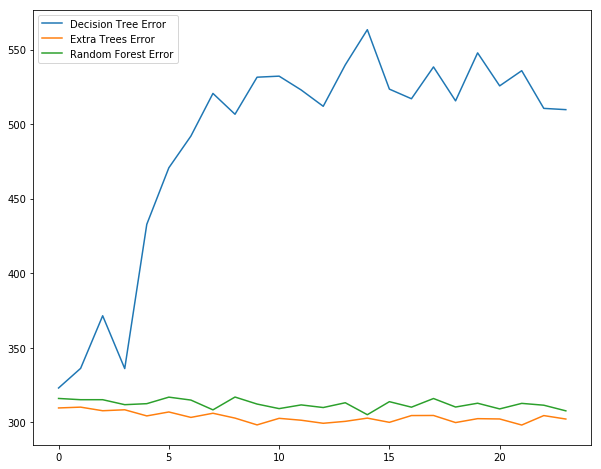

In [61]:
import matplotlib.pyplot as plt

# Plotting RMSE's for points
plt.figure(figsize=(10, 8))
plt.plot(np.array(DT_errors)[:, 0], label='Decision Tree Error')
plt.plot(np.array(ET_errors)[:, 0], label='Extra Trees Error')
plt.plot(np.array(RF_errors)[:, 0], label='Random Forest Error')
plt.legend()
plt.show();

### 4. Neural Networks

In [62]:
# Shuffle the data up
X_train, X_test, y_train, y_test = shuffle(train, test)

In [63]:
# Standardize data
norm_X_train, norm_X_test, x_means, x_stds = standardize(X_train, X_test)

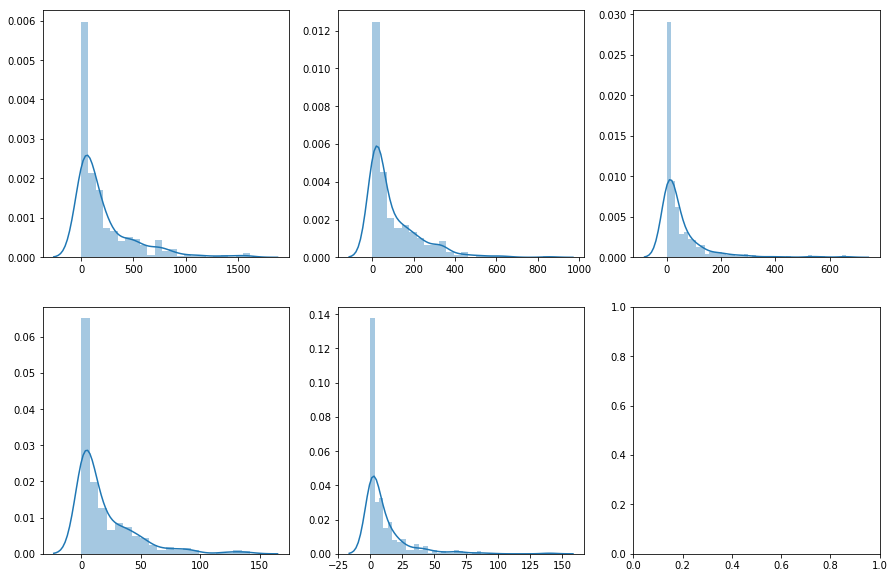

In [64]:
# Y-value skewness
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col_num in range(len(y_train.columns)):
    sns.distplot(y_train.iloc[:, col_num].to_frame(), ax=axes[col_num // 3][col_num % 3]);

In [65]:
### STANDARDIZE Y-VALUES (this is because y_values are so skewed)
norm_y_train, _, y_means, y_stds = standardize(y_train, y_test)

In [66]:
# Import libraries for model
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [67]:
def make_nn_arch():
    """
    Make basic neural network architecture for our dataset.
    """
    model = Sequential()
    model.add(Dense(35, activation='tanh', input_shape=(28,)))
    model.add(Dense(15, activation='tanh', input_shape=(35,)))
    model.add(Dense(1, activation='tanh', input_shape=(15,)))
    # For a mean squared error regression problem
    model.compile(
        optimizer=keras.optimizers.SGD(
            lr=0.001,
            momentum=0.9,
            nesterov=True
        ), #How to Learn
        loss='mse', # What to Learn
    )
    return model

In [68]:
# Create and fit Neural Network
model = make_nn_arch()
model.fit(
    x=norm_X_train,
    y=norm_y_train['NBA_points'], 
    epochs=100,
)

Epoch 1/100
420/420 [==============================] - 0s 895us/step - loss: 1.1607
Epoch 2/100
420/420 [==============================] - 0s 148us/step - loss: 0.9980
Epoch 3/100
420/420 [==============================] - 0s 102us/step - loss: 0.9669
Epoch 4/100
420/420 [==============================] - 0s 133us/step - loss: 0.9422
Epoch 5/100
420/420 [==============================] - 0s 88us/step - loss: 0.9287
Epoch 6/100
420/420 [==============================] - 0s 155us/step - loss: 0.9138
Epoch 7/100
420/420 [==============================] - 0s 136us/step - loss: 0.8980
Epoch 8/100
420/420 [==============================] - 0s 99us/step - loss: 0.8922
Epoch 9/100
420/420 [==============================] - 0s 82us/step - loss: 0.8869
Epoch 10/100
420/420 [==============================] - 0s 91us/step - loss: 0.8733
Epoch 11/100
420/420 [==============================] - 0s 123us/step - loss: 0.8706
Epoch 12/100
420/420 [==============================] - 0s 86us/step - loss: 0

420/420 [==============================] - 0s 69us/step - loss: 0.6615
Epoch 99/100
420/420 [==============================] - 0s 94us/step - loss: 0.6632
Epoch 100/100
420/420 [==============================] - 0s 153us/step - loss: 0.6596


In [69]:
# Loss function
def RMSE(y, y_pred):
    """
    Calculates the root mean squared error of the model's predictions.
    """
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [70]:
# Make predictions
y_pred = model.predict(norm_X_test)

In [71]:
# RMSE for points
RMSE(((y_pred * y_stds['NBA_points']) + y_means['NBA_points']).flatten(), y_test['NBA_points'])

292.2282011732972

### 4.1 Make Neural Networks for all stats

In [72]:
def train_all_and_predict():
    
    rmses = []
    
    for column in y_train.columns:

        # Create and fit Neural Network
        model = make_nn_arch()
        model.fit(
            x=norm_X_train,
            y=norm_y_train[column], 
            epochs=100,
        )
        y_pred = model.predict(norm_X_test)

        # RMSE by stat category
        rmse = RMSE(((y_pred * y_stds[column]) + y_means[column]).flatten(), y_test[column])
        rmses.append(rmse)
    
    return rmses

In [73]:
rmses = train_all_and_predict()

Epoch 1/100
420/420 [==============================] - 0s 271us/step - loss: 1.0247
Epoch 2/100
420/420 [==============================] - 0s 94us/step - loss: 0.9397
Epoch 3/100
420/420 [==============================] - 0s 90us/step - loss: 0.9068
Epoch 4/100
420/420 [==============================] - 0s 146us/step - loss: 0.8941
Epoch 5/100
420/420 [==============================] - 0s 152us/step - loss: 0.8885
Epoch 6/100
420/420 [==============================] - 0s 165us/step - loss: 0.8859
Epoch 7/100
420/420 [==============================] - 0s 85us/step - loss: 0.8760
Epoch 8/100
420/420 [==============================] - 0s 92us/step - loss: 0.8737
Epoch 9/100
420/420 [==============================] - 0s 60us/step - loss: 0.8688
Epoch 10/100
420/420 [==============================] - 0s 60us/step - loss: 0.8641
Epoch 11/100
420/420 [==============================] - 0s 104us/step - loss: 0.8613
Epoch 12/100
420/420 [==============================] - 0s 94us/step - loss: 0.8

420/420 [==============================] - 0s 57us/step - loss: 0.6973
Epoch 99/100
420/420 [==============================] - 0s 64us/step - loss: 0.6967
Epoch 100/100
420/420 [==============================] - 0s 97us/step - loss: 0.6934
Epoch 1/100
420/420 [==============================] - 0s 269us/step - loss: 1.1856
Epoch 2/100
420/420 [==============================] - 0s 51us/step - loss: 0.9754
Epoch 3/100
420/420 [==============================] - 0s 70us/step - loss: 0.9117
Epoch 4/100
420/420 [==============================] - 0s 85us/step - loss: 0.8750
Epoch 5/100
420/420 [==============================] - 0s 92us/step - loss: 0.8629
Epoch 6/100
420/420 [==============================] - 0s 57us/step - loss: 0.8487
Epoch 7/100
420/420 [==============================] - 0s 102us/step - loss: 0.8410
Epoch 8/100
420/420 [==============================] - 0s 78us/step - loss: 0.8339
Epoch 9/100
420/420 [==============================] - 0s 64us/step - loss: 0.8310
Epoch 10/10

420/420 [==============================] - 0s 60us/step - loss: 0.6368
Epoch 96/100
420/420 [==============================] - 0s 77us/step - loss: 0.6328
Epoch 97/100
420/420 [==============================] - 0s 47us/step - loss: 0.6313
Epoch 98/100
420/420 [==============================] - 0s 77us/step - loss: 0.6301
Epoch 99/100
420/420 [==============================] - 0s 58us/step - loss: 0.6269
Epoch 100/100
420/420 [==============================] - 0s 122us/step - loss: 0.6245
Epoch 1/100
420/420 [==============================] - 0s 300us/step - loss: 1.2189
Epoch 2/100
420/420 [==============================] - 0s 81us/step - loss: 0.9705
Epoch 3/100
420/420 [==============================] - 0s 61us/step - loss: 0.8707
Epoch 4/100
420/420 [==============================] - 0s 92us/step - loss: 0.8418
Epoch 5/100
420/420 [==============================] - 0s 81us/step - loss: 0.8252
Epoch 6/100
420/420 [==============================] - 0s 148us/step - loss: 0.8187
Epoch 7

420/420 [==============================] - 0s 55us/step - loss: 0.6895
Epoch 93/100
420/420 [==============================] - 0s 78us/step - loss: 0.6876
Epoch 94/100
420/420 [==============================] - 0s 86us/step - loss: 0.6873
Epoch 95/100
420/420 [==============================] - 0s 115us/step - loss: 0.6847
Epoch 96/100
420/420 [==============================] - 0s 48us/step - loss: 0.6868
Epoch 97/100
420/420 [==============================] - 0s 204us/step - loss: 0.6857
Epoch 98/100
420/420 [==============================] - 0s 96us/step - loss: 0.6845
Epoch 99/100
420/420 [==============================] - 0s 66us/step - loss: 0.6829
Epoch 100/100
420/420 [==============================] - 0s 49us/step - loss: 0.6805
Epoch 1/100
420/420 [==============================] - 0s 277us/step - loss: 1.2547
Epoch 2/100
420/420 [==============================] - 0s 84us/step - loss: 1.0950
Epoch 3/100
420/420 [==============================] - 0s 77us/step - loss: 0.9745
Epoc

420/420 [==============================] - 0s 72us/step - loss: 0.6778
Epoch 90/100
420/420 [==============================] - 0s 82us/step - loss: 0.6782
Epoch 91/100
420/420 [==============================] - 0s 66us/step - loss: 0.6784
Epoch 92/100
420/420 [==============================] - 0s 72us/step - loss: 0.6766
Epoch 93/100
420/420 [==============================] - 0s 81us/step - loss: 0.6742
Epoch 94/100
420/420 [==============================] - 0s 81us/step - loss: 0.6728
Epoch 95/100
420/420 [==============================] - 0s 122us/step - loss: 0.6698
Epoch 96/100
420/420 [==============================] - 0s 170us/step - loss: 0.6682
Epoch 97/100
420/420 [==============================] - 0s 66us/step - loss: 0.6689
Epoch 98/100
420/420 [==============================] - 0s 72us/step - loss: 0.6691
Epoch 99/100
420/420 [==============================] - 0s 77us/step - loss: 0.6643
Epoch 100/100
420/420 [==============================] - 0s 88us/step - loss: 0.6633
Ep

420/420 [==============================] - 0s 55us/step - loss: 0.6803
Epoch 87/100
420/420 [==============================] - 0s 112us/step - loss: 0.6785
Epoch 88/100
420/420 [==============================] - 0s 52us/step - loss: 0.6810
Epoch 89/100
420/420 [==============================] - 0s 81us/step - loss: 0.6767
Epoch 90/100
420/420 [==============================] - 0s 78us/step - loss: 0.6770
Epoch 91/100
420/420 [==============================] - 0s 91us/step - loss: 0.6744
Epoch 92/100
420/420 [==============================] - 0s 74us/step - loss: 0.6731
Epoch 93/100
420/420 [==============================] - 0s 67us/step - loss: 0.6716
Epoch 94/100
420/420 [==============================] - 0s 71us/step - loss: 0.6707
Epoch 95/100
420/420 [==============================] - 0s 56us/step - loss: 0.6697
Epoch 96/100
420/420 [==============================] - 0s 84us/step - loss: 0.6696
Epoch 97/100
420/420 [==============================] - 0s 82us/step - loss: 0.6669
Epoc

In [74]:
rmses

[290.7638609948038,
 138.49158479751992,
 56.43647707234934,
 21.332715324960553,
 20.12454745302167]

# D. Training the final models

In [75]:
####################
### FINAL MODELS ###
####################

In [ ]:
# Train your best models here! Remove any comments if you don't need them.

# Standardize data

# Split data

# Train models

# Predict

# Calculate RMSE

In [76]:
# Standardize data
X_means, X_stds = train.mean(), train.std()
y_means, y_stds = test.mean(), test.std()
X_norm = (train - X_means) / X_stds
y_norm = (test - y_means) / y_stds

In [77]:
def train_all(X_train, y_train):
    """
    Trains all 5 Neural Networks we need for the 5 stat categories.
    """
    models = {}
    
    for column in y_train.columns:

        # Create and fit Neural Network
        model = make_nn_arch()
        model.fit(
            x=X_train,
            y=y_train[column], 
            epochs=100,
        )
        models[column] = model
        
    return models

In [82]:
# {"Points": NeuralNetworkObject, "Rebounds"...}
nn_models = train_all(X_norm, y_norm)

Epoch 1/100
525/525 [==============================] - 0s 260us/step - loss: 1.1353
Epoch 2/100
525/525 [==============================] - 0s 106us/step - loss: 0.9827
Epoch 3/100
525/525 [==============================] - 0s 173us/step - loss: 0.9484
Epoch 4/100
525/525 [==============================] - 0s 80us/step - loss: 0.9323
Epoch 5/100
525/525 [==============================] - 0s 94us/step - loss: 0.9180
Epoch 6/100
525/525 [==============================] - 0s 114us/step - loss: 0.9086
Epoch 7/100
525/525 [==============================] - 0s 95us/step - loss: 0.9018
Epoch 8/100
525/525 [==============================] - 0s 111us/step - loss: 0.8944
Epoch 9/100
525/525 [==============================] - 0s 88us/step - loss: 0.8924
Epoch 10/100
525/525 [==============================] - 0s 78us/step - loss: 0.8832
Epoch 11/100
525/525 [==============================] - 0s 136us/step - loss: 0.8775
Epoch 12/100
525/525 [==============================] - 0s 124us/step - loss: 0

525/525 [==============================] - 0s 114us/step - loss: 0.6530
Epoch 99/100
525/525 [==============================] - 0s 88us/step - loss: 0.6503
Epoch 100/100
525/525 [==============================] - 0s 120us/step - loss: 0.6489
Epoch 1/100
525/525 [==============================] - 0s 218us/step - loss: 1.3060
Epoch 2/100
525/525 [==============================] - 0s 59us/step - loss: 1.0120
Epoch 3/100
525/525 [==============================] - 0s 65us/step - loss: 0.9425
Epoch 4/100
525/525 [==============================] - 0s 66us/step - loss: 0.9166
Epoch 5/100
525/525 [==============================] - 0s 59us/step - loss: 0.8956
Epoch 6/100
525/525 [==============================] - 0s 54us/step - loss: 0.8825
Epoch 7/100
525/525 [==============================] - 0s 100us/step - loss: 0.8728
Epoch 8/100
525/525 [==============================] - 0s 71us/step - loss: 0.8635
Epoch 9/100
525/525 [==============================] - 0s 100us/step - loss: 0.8559
Epoch 10

525/525 [==============================] - 0s 91us/step - loss: 0.6409
Epoch 96/100
525/525 [==============================] - 0s 42us/step - loss: 0.6383
Epoch 97/100
525/525 [==============================] - 0s 60us/step - loss: 0.6383
Epoch 98/100
525/525 [==============================] - 0s 60us/step - loss: 0.6397
Epoch 99/100
525/525 [==============================] - 0s 54us/step - loss: 0.6322
Epoch 100/100
525/525 [==============================] - 0s 47us/step - loss: 0.6341
Epoch 1/100
525/525 [==============================] - 0s 199us/step - loss: 1.3496
Epoch 2/100
525/525 [==============================] - 0s 58us/step - loss: 0.9702
Epoch 3/100
525/525 [==============================] - 0s 58us/step - loss: 0.8908
Epoch 4/100
525/525 [==============================] - 0s 71us/step - loss: 0.8568
Epoch 5/100
525/525 [==============================] - 0s 79us/step - loss: 0.8369
Epoch 6/100
525/525 [==============================] - 0s 88us/step - loss: 0.8251
Epoch 7/1

525/525 [==============================] - 0s 42us/step - loss: 0.6865
Epoch 93/100
525/525 [==============================] - 0s 54us/step - loss: 0.6868
Epoch 94/100
525/525 [==============================] - 0s 61us/step - loss: 0.6849
Epoch 95/100
525/525 [==============================] - 0s 70us/step - loss: 0.6842
Epoch 96/100
525/525 [==============================] - 0s 44us/step - loss: 0.6847
Epoch 97/100
525/525 [==============================] - 0s 83us/step - loss: 0.6831
Epoch 98/100
525/525 [==============================] - 0s 70us/step - loss: 0.6812
Epoch 99/100
525/525 [==============================] - 0s 78us/step - loss: 0.6804
Epoch 100/100
525/525 [==============================] - 0s 68us/step - loss: 0.6800
Epoch 1/100
525/525 [==============================] - 0s 328us/step - loss: 1.1299
Epoch 2/100
525/525 [==============================] - 0s 128us/step - loss: 0.9837
Epoch 3/100
525/525 [==============================] - 0s 55us/step - loss: 0.9311
Epoch

525/525 [==============================] - 0s 109us/step - loss: 0.6770
Epoch 90/100
525/525 [==============================] - 0s 75us/step - loss: 0.6764
Epoch 91/100
525/525 [==============================] - 0s 77us/step - loss: 0.6723
Epoch 92/100
525/525 [==============================] - 0s 62us/step - loss: 0.6715
Epoch 93/100
525/525 [==============================] - 0s 69us/step - loss: 0.6711
Epoch 94/100
525/525 [==============================] - 0s 73us/step - loss: 0.6701
Epoch 95/100
525/525 [==============================] - 0s 107us/step - loss: 0.6678
Epoch 96/100
525/525 [==============================] - 0s 43us/step - loss: 0.6652
Epoch 97/100
525/525 [==============================] - 0s 59us/step - loss: 0.6635
Epoch 98/100
525/525 [==============================] - 0s 49us/step - loss: 0.6625
Epoch 99/100
525/525 [==============================] - 0s 66us/step - loss: 0.6609
Epoch 100/100
525/525 [==============================] - 0s 143us/step - loss: 0.6604
E

525/525 [==============================] - 0s 54us/step - loss: 0.7056
Epoch 87/100
525/525 [==============================] - 0s 69us/step - loss: 0.7045
Epoch 88/100
525/525 [==============================] - 0s 50us/step - loss: 0.7040
Epoch 89/100
525/525 [==============================] - 0s 69us/step - loss: 0.7026
Epoch 90/100
525/525 [==============================] - 0s 41us/step - loss: 0.7023
Epoch 91/100
525/525 [==============================] - 0s 114us/step - loss: 0.7007
Epoch 92/100
525/525 [==============================] - 0s 49us/step - loss: 0.6996
Epoch 93/100
525/525 [==============================] - 0s 91us/step - loss: 0.7001
Epoch 94/100
525/525 [==============================] - 0s 128us/step - loss: 0.6993
Epoch 95/100
525/525 [==============================] - 0s 47us/step - loss: 0.6974
Epoch 96/100
525/525 [==============================] - 0s 60us/step - loss: 0.6956
Epoch 97/100
525/525 [==============================] - 0s 73us/step - loss: 0.6955
Epo

In [79]:
@anvil.server.callable
def get_predicts(name):
    """
    Return a one-item list with the dictionary in it.
    If doesn't exist, return empty list
    """

    def rename_cols(name):
        """
        Rename columns
        """
        new_names = {
            'NBA_points': 'pts',
            'NBA_total_rebounds': 'reb',
            'NBA_assists': 'ast',
            'NBA_steals': 'stl',
            'NBA_blocks': 'blk',
        }
        if name == 'Name':
            return name
        return new_names[name]
    
    player_data = format_data(get_college_stats(name)['data'], train)
    player_norm = (player_data - X_means) / X_stds
    
    preds = {}
    preds['Name'] = name
    
    # Make predictions and de-standardize
    for model_name in nn_models.keys():
        stat_pred = nn_models[model_name].predict(player_norm)
        preds[rename_cols(model_name)] = max(int((stat_pred * y_stds[model_name]) + y_means[model_name]), 0) / 25 # Non-zero predictions, and making them per-game stats
    
    return [preds]

In [83]:
def run():
    while True:
        name = input()
        if name == 'exit' or name == 'quit':
            break
        print(get_predicts(name))
# name = 'Stephen Curry'

In [85]:
run()

Kyrie Irving
[{'Name': 'Kyrie Irving', 'pts': 0.0, 'reb': 2.48, 'ast': 0.64, 'stl': 0.0, 'blk': 0.0}]
exit


In [101]:
s = get_college_stats('Stephen Curry')

In [113]:
train

,NCAAB_assists,NCAAB_blocks,NCAAB_field_goal_attempts,NCAAB_field_goal_percentage,NCAAB_field_goals,NCAAB_free_throw_attempt_rate,NCAAB_free_throw_attempts,NCAAB_free_throw_percentage,NCAAB_free_throws,NCAAB_games_played,...,NCAAB_total_rebound_percentage,NCAAB_total_rebounds,NCAAB_turnover_percentage,NCAAB_turnovers,NCAAB_two_point_attempts,NCAAB_two_point_percentage,NCAAB_win_shares,Center,Forward,Guard
name,,,,,,,,,,,,,,,,,,,,,
Landry Fields,89.0,25.0,506.0,0.490,248.0,0.508,257.0,0.696,179.0,32.0,...,14.1,280.0,11.7,83.0,420.0,0.521,6.0,0,0,1
Andy Rautins,171.0,8.0,297.0,0.438,130.0,0.273,81.0,0.815,66.0,35.0,...,5.8,118.0,22.6,98.0,56.0,0.571,4.9,0,0,1
Patrick Patterson,36.0,51.0,374.0,0.575,215.0,0.348,130.0,0.692,90.0,38.0,...,12.1,283.0,8.6,41.0,305.0,0.626,7.0,0,1,0
Gani Lawal,15.0,49.0,325.0,0.529,172.0,0.683,222.0,0.572,127.0,36.0,...,17.6,305.0,15.3,78.0,324.0,0.531,4.1,0,1,0
Cole Aldrich,31.0,125.0,265.0,0.562,149.0,0.600,159.0,0.679,108.0,36.0,...,20.0,354.0,14.1,56.0,265.0,0.562,5.9,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jaron Blossomgame,51.0,30.0,441.0,0.499,220.0,0.381,168.0,0.714,120.0,33.0,...,10.6,207.0,9.7,56.0,347.0,0.565,4.3,0,1,0
Collin Sexton,119.0,3.0,438.0,0.447,196.0,0.575,252.0,0.778,196.0,33.0,...,7.0,124.0,14.2,92.0,307.0,0.495,4.4,0,0,1
Jevon Carter,246.0,13.0,509.0,0.422,215.0,0.305,155.0,0.858,133.0,37.0,...,7.5,172.0,14.4,98.0,313.0,0.441,7.0,0,0,1


In [ ]:
format_data()

In [111]:
format_data(get_college_stats('Stephen Curry')['data'], train)

,NCAAB_assists,NCAAB_blocks,NCAAB_field_goal_attempts,NCAAB_field_goal_percentage,NCAAB_field_goals,NCAAB_free_throw_attempt_rate,NCAAB_free_throw_attempts,NCAAB_free_throw_percentage,NCAAB_free_throws,NCAAB_games_played,...,NCAAB_total_rebound_percentage,NCAAB_total_rebounds,NCAAB_turnover_percentage,NCAAB_turnovers,NCAAB_two_point_attempts,NCAAB_two_point_percentage,NCAAB_win_shares,Guard,Forward,Center
Name,,,,,,,,,,,,,,,,,,,,,
Stephen Curry,189,8,687,0.454,312,0.365,251,0.876,220,34,...,6.9,151,13.5,126,351,0.519,9.9,1,0,0


In [105]:
NCAAB_Player('stephen-curry-1')

In [104]:
s['data']

,NCAAB_assist_percentage,NCAAB_assists,NCAAB_block_percentage,NCAAB_blocks,NCAAB_box_plus_minus,NCAAB_conference,NCAAB_defensive_box_plus_minus,NCAAB_defensive_rebound_percentage,NCAAB_defensive_rebounds,NCAAB_defensive_win_shares,...,NCAAB_true_shooting_percentage,NCAAB_turnover_percentage,NCAAB_turnovers,NCAAB_two_point_attempts,NCAAB_two_point_percentage,NCAAB_two_pointers,NCAAB_usage_percentage,NCAAB_weight,NCAAB_win_shares,NCAAB_win_shares_per_40_minutes
Name,,,,,,,,,,,,,,,,,,,,,
Stephen Curry,40.2,189,0.6,8,None,southern,None,None,130,3.6,...,0.604,13.5,126,351,0.519,182,38.3,185,9.9,0.348


In [97]:
run()

Stephen Curry
[{'Name': 'Stephen Curry', 'pts': 16.32, 'reb': 4.84, 'ast': 4.36, 'stl': 0.76, 'blk': 0.64}]
exit


In [98]:
get_college('Zion Williamson')

{'success': True,
 'data': [{'pts': 22.61,
   'reb': 8.88,
   'ast': 2.06,
   'stl': 2.12,
   'blk': 1.79,
   'Name': 'Zion Williamson'}],
 'error': None}